<a href="https://colab.research.google.com/github/nicholashagemann/lambdalectures/blob/main/DS29_GP_Unit2_Sprint3_Module1_Nivi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OVERVIEW

1. Announcements
2. Build week discussion
3. Setting up local environment (Github cloning and pip setup)
4. Working on Burrito data set 
5. ROC 
6. Classification vs regression
7. Project Module review


In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve
import matplotlib.pyplot as plt

# OVERVIEW
# This is the data science process at a high level:

<img src="https://image.slidesharecdn.com/becomingadatascientistadvice-pydatadc-shared-161012184823/95/becoming-a-data-scientist-advice-from-my-podcast-guests-55-638.jpg?cb=1476298295">

—Renee Teate, [Becoming a Data Scientist, PyData DC 2016 Talk](https://www.becomingadatascientist.com/2016/10/11/pydata-dc-2016-talk/)

We've focused on the 2nd arrow in the diagram, by training predictive models. Now let's zoom out and focus on the 1st arrow: defining problems, by translating business questions into code/data questions.

Last sprint, you did a Kaggle Challenge. It’s a great way to practice model validation and other technical skills. But that's just part of the modeling process. [Kaggle gets critiqued](https://speakerdeck.com/szilard/machine-learning-software-in-practice-quo-vadis-invited-talk-kdd-conference-applied-data-science-track-august-2017-halifax-canada?slide=119) because some things are done for you: Like [**defining the problem!**](https://www.linkedin.com/pulse/data-science-taught-universities-here-why-maciej-wasiak/) In today’s module, you’ll begin to practice this objective, with your dataset you’ve chosen for your personal portfolio project.

When defining a supervised machine learning problem, one of the first steps is choosing a target to predict.

## Burrito Dataset

Which column in your tabular dataset will you predict?

Is your problem regression or classification? You have options. Sometimes it’s not straightforward, as we'll see below.

- Discrete, ordinal, low cardinality target: Can be regression or multi-class classification.
- (In)equality comparison: Converts regression or multi-class classification to binary classification.
- Predicted probability: Seems to [blur](https://brohrer.github.io/five_questions_data_science_answers.html) the line between classification and regression.

# Define ML problems

# I. Wrangle Data

**Question:** What issues do we need to address in our `wrangle` function?

- "Weird values," eg. Yes/No/True/False/X/x/0/1
- High cardinality categorical features

In [ ]:
def wrangle(filepath):
    df = pd.read_csv(filepath, parse_dates=['Date'], index_col='Date')

    # Clean binary encoded columns
    categorical_cols = df.select_dtypes('object').columns
    binary_cols = [col for col in categorical_cols if df[col].nunique() < 4]
    for col in binary_cols:
        df[col] = df[col].apply(lambda x: 1 if isinstance(x, str) else 0)
    
    # Drop high-cardinality categorical variables
    threshold = 10
    high_card_cols = [col for col in categorical_cols 
                      if df[col].nunique() > threshold]
    df.drop(high_card_cols, axis=1, inplace=True)

    # Create `'great'` column as target
    df['great'] = (df['overall'] >= 4).astype(int)
    df.drop(columns='overall', inplace=True)

    # Dropping columns with high number of NaN values
    df.dropna(axis=1,thresh=300,inplace=True)

    return df

In [ ]:
df = wrangle(DATA_PATH+'burritos/burritos.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 423 entries, 2016-01-18 to 2019-08-27
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Cost           416 non-null    float64
 1   Hunger         420 non-null    float64
 2   Tortilla       423 non-null    float64
 3   Temp           403 non-null    float64
 4   Meat           409 non-null    float64
 5   Fillings       420 non-null    float64
 6   Meat:filling   414 non-null    float64
 7   Uniformity     421 non-null    float64
 8   Salsa          398 non-null    float64
 9   Synergy        421 non-null    float64
 10  Wrap           420 non-null    float64
 11  overall        421 non-null    float64
 12  Unreliable     423 non-null    int64  
 13  NonSD          423 non-null    int64  
 14  Beef           423 non-null    int64  
 15  Pico           423 non-null    int64  
 16  Guac           423 non-null    int64  
 17  Cheese         423 non-null    int6

In [ ]:
df.head()

,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,6.49,3.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.45,3.5,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,4.85,1.5,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-24,5.25,2.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-01-27,6.59,4.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# II. Split Data

In [ ]:
target = 'great'
y = df[target]
X = df.drop(target, axis=1)

In [ ]:
X.shape, y.shape

((423, 48), (423,))

In [ ]:
y.value_counts()

0    241
1    182
Name: great, dtype: int64

In [ ]:
# training data before 2017
train_mask = X.index.year < 2017
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

# validation data during 2017
val_mask = X.index.year == 2017
X_val, y_val = X.loc[val_mask], y.loc[val_mask]

# test data after 2017
test_mask = X.index.year > 2017
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

# III. Establish Baseline

In [ ]:
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.5933333333333334


In [ ]:
y_train.value_counts(normalize=True)

0    0.593333
1    0.406667
Name: great, dtype: float64

# IV. Build Model

- `LogisticRegression`
    - `SimpleImputer`
    - `StandardScaler`

In [ ]:
model_lr = make_pipeline(SimpleImputer(),
                         StandardScaler(),
                         LogisticRegression())
model_lr.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

- `RandomForestClassifier`
    - `SimpleImputer`

In [ ]:
model_rf = make_pipeline(SimpleImputer(),
                         RandomForestClassifier())
model_rf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=F

# V. Check Metrics

**Accuracy**

In [ ]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.91
Validation Accuracy (LOGR): 0.7647058823529411


In [ ]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.8470588235294118


**Precision, Recall, F1**

Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.66      0.76        47
           1       0.68      0.89      0.77        38

    accuracy                           0.76        85
   macro avg       0.78      0.78      0.76        85
weighted avg       0.79      0.76      0.76        85



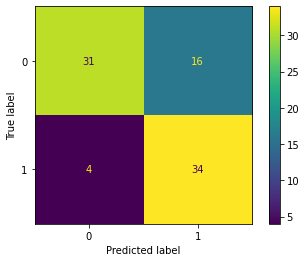

In [ ]:
print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))
plot_confusion_matrix(model_lr, X_val, y_val);

Random Forest
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        47
           1       0.80      0.87      0.84        38

    accuracy                           0.85        85
   macro avg       0.85      0.85      0.85        85
weighted avg       0.85      0.85      0.85        85



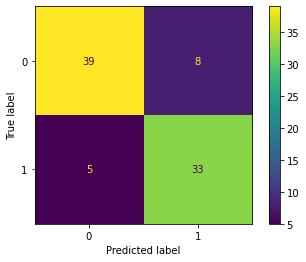

In [ ]:
print('Random Forest')
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_val);

**ROC curve**

- To evaluate models for binary classification.
- Decide what probability threshold you should use when making your predictions.

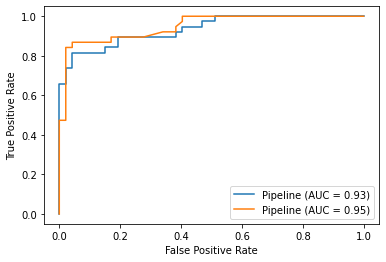

In [ ]:
lr = plot_roc_curve(model_lr,X_val,y_val)
rf = plot_roc_curve(model_rf,X_val,y_val,ax =lr.ax_)

In [ ]:
# Get predicted probabilities from model
y_pred_prob = model_rf.predict_proba(X_val)[:, -1]

# Input true labels and probability predictions
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Put data into dictionary
data = {'false_pos_rate': fpr,
        'true_pos_rate': tpr, 
        'thresholds': thresholds}

pd.DataFrame(data)

,false_pos_rate,true_pos_rate,thresholds
0,0.000000,0.000000,1.99
1,0.000000,0.078947,0.99
2,0.000000,0.131579,0.98
3,0.000000,0.210526,0.97
4,0.000000,0.263158,0.93
5,0.000000,0.315789,0.92
6,0.000000,0.473684,0.85
7,0.021277,0.473684,0.82
8,0.021277,0.552632,0.77
9,0.021277,0.605263,0.76
